In [1]:
import json
import cv2  
import glob
import numpy as np
import pandas as pd
import os
import string
import shutup
shutup.mute_warnings()

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')

# MediCat dataset statistics

In [2]:
figures_data = pd.read_json(path_or_buf='s2_full_figures_oa_nonroco_combined_medical_top4_public.jsonl', 
                            lines=True)
subcapt_data = pd.read_json(path_or_buf='subcaptions_public.jsonl', lines=True)

In [3]:
figures_data.keys(), subcapt_data.keys()

(Index(['pdf_hash', 'fig_key', 'fig_uri', 's2_caption', 's2orc_caption',
        's2orc_references', 'radiology', 'scope', 'predicted_type', 'oa_info'],
       dtype='object'),
 Index(['pdf_hash', 'fig_key', 'fig_uri', 'text', 'width', 'height',
        'subcaptions', 'subfigures', 'tokens'],
       dtype='object'))

In [4]:
figures_data.iloc[0]

pdf_hash                     26491ab76c6e8d6acc582e71bb6b3b5f5601ccc2
fig_key                                                       Figure4
fig_uri                                               3-Figure4-1.png
s2_caption          Figure 4. Nuclear magnetic resonance scan demo...
s2orc_caption       Figure 4. Nuclear magnetic resonance scan demo...
s2orc_references    [Findings from nuclear magnetic resonance imag...
radiology                                                        True
scope                                                           False
predicted_type                                         Medical images
oa_info             {'doi': '10.1001/archopht.117.11.1553', 'doi_u...
Name: 0, dtype: object

In [5]:
figures_data.iloc[0]['s2_caption']

'Figure 4. Nuclear magnetic resonance scan demonstrating the occipital lesion with irregular borders surrounded by slight edema.'

In [6]:
subcapt_data.iloc[0]['text']

'Fig. 1. An illustrative case. A-D: Initial MRI findings. E-H: Follow-up imaging after 7 months without surgical intervention.'

In [7]:
# TODO: check difference between subcaption and caption

#### Note on captions:
To add inline references, we match extracted figures to corresponding figures in the publicly-available S2ORC corpus , then extract inline references for these figures from the S2ORC full text

In [8]:
def caption_to_figure(caption_dict):
    figure_file_name = '_'.join([caption_dict['pdf_hash'], caption_dict['fig_uri']])
    return figure_file_name

## Distribution of datasets + length of the captions

In [9]:
# Number of figures that are from radiology
figures_data.groupby('radiology').sum()

,scope
radiology,
False,8007
True,1840


In [10]:
# Number of figures that are scope images
figures_data.groupby('scope').sum()

,radiology
scope,
False,139513
True,1840


In [11]:
def count_num_words(line):
    if line:
        num_words = len(line.split(' '))
    else:
        num_words = 0
    return num_words

figures_data['num_words'] = figures_data['s2_caption'].apply(lambda x: count_num_words(x))

print('Min number of words per caption string: {} \nMax number of words: {}'.format(
    figures_data['num_words'].min(), figures_data['num_words'].max()))
print('Mean number of words: {} \nMedian number of words: {}'.format(
    figures_data['num_words'].mean(), figures_data['num_words'].median()))

Min number of words per caption string: 2 
Max number of words: 839
Mean number of words: 59.67749470192574 
Median number of words: 47.0


In [12]:
figures_data['num_words_orc'] = figures_data['s2orc_caption'].apply(lambda x: count_num_words(x))

print('Min number of words per ORC caption: {} \nMax number of words: {}'.format(
    figures_data['num_words_orc'].min(), figures_data['num_words_orc'].max()))
print('Mean number of words: {} \nMedian number of words: {}'.format(
    figures_data['num_words_orc'].mean(), figures_data['num_words_orc'].median()))

Min number of words per ORC caption: 0 
Max number of words: 953
Mean number of words: 47.30862895052059 
Median number of words: 35.0


In [13]:
figures_data['references_len'] = figures_data['s2orc_references'].apply(lambda x: len(x) if x else 0)
figures_data['references_len'].mean(), figures_data['references_len'].median()

(1.373320740808993, 1.0)

### Statistics for subcaptions text

In [14]:
# 'text', 'width', 'height', 'subcaptions', 'subfigures', 'tokens'

In [15]:
subcapt_data['num_words'] = subcapt_data['text'].apply(lambda x: count_num_words(x))

print('Min number of words per subcaption string: {} \nMax number of words: {}'.format(
    subcapt_data['num_words'].min(), subcapt_data['num_words'].max()))
print('Mean number of words: {} \nMedian number of words: {}'.format(
    subcapt_data['num_words'].mean(), subcapt_data['num_words'].median()))

Min number of words per subcaption string: 6 
Max number of words: 497
Mean number of words: 74.68838526912181 
Median number of words: 62.0


## Clean text 

In [16]:
def preprocess_text(text):
    # Converting to lower case - normalizing text by converting all characters to the same format 
    text = text.lower()
    
    # Remove stop words
    word_list = nltk.word_tokenize(text)
    stop = set(stopwords.words('english'))
    word_list = [w for w in word_list if not w.lower() in stop]
    
    # Converting each word to its base form and obtaining lemmas
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    # Removing all punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

figures_data['cleaned_text'] = figures_data['s2_caption'].apply(lambda x : preprocess_text(x))

## Cluster captions

In [17]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

X_tfidf = vectorizer.fit_transform(figures_data['cleaned_text'])

In [18]:
kmeans = KMeans(
        n_clusters=4,
        max_iter=100,
        n_init=1,
        random_state=42,
    )

kmeans.fit(X_tfidf)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of elements asigned to each cluster: {cluster_sizes}")

Number of elements asigned to each cluster: [ 22674 116409  45114  32863]


In [19]:
clf = TruncatedSVD(2)
Xpca = clf.fit_transform(X_tfidf)
Xpca.shape

(217060, 2)

cluster: 0


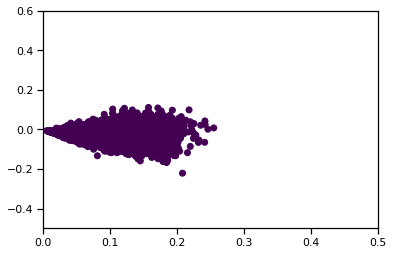

cluster: 1


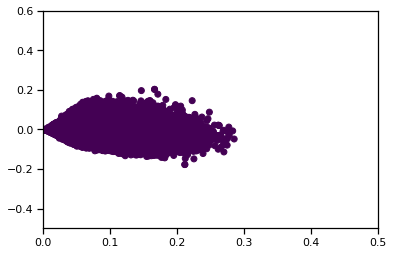

cluster: 2


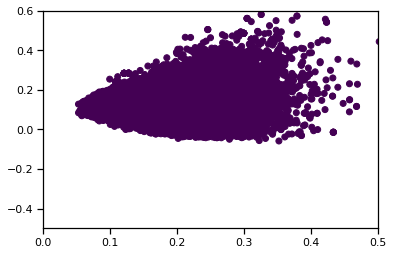

cluster: 3


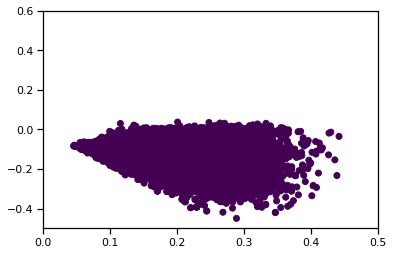

In [20]:
# Visualize
y_pred = kmeans.predict(X_tfidf)

for class_ind in range(4):
    selec_0 = Xpca[:,0][y_pred==class_ind]
    selec_1 = Xpca[:,1][y_pred==class_ind]
    print('cluster: {}'.format(class_ind))
    plt.scatter(selec_0, selec_1, c=y_pred[y_pred==class_ind], cmap=plt.cm.viridis) 
    plt.xlim(0.0, 0.5)
    plt.ylim(-.50,.6)
#     plt.axis('off') 
    # plt.scatter(Xpca[:,0], Xpca[:,1], c=y_pred, cmap=plt.cm.viridis) 
    plt.show() 
plt.show()

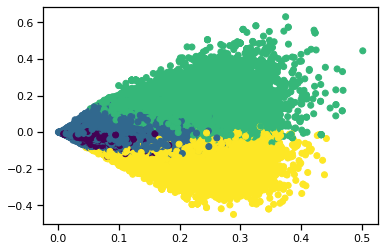

In [21]:
y_pred = kmeans.predict(X_tfidf)

plt.scatter(Xpca[:,0], Xpca[:,1], c=y_pred, cmap=plt.cm.viridis) 
plt.show()

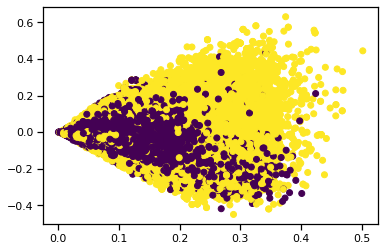

In [22]:
true_y = figures_data['radiology']

plt.scatter(Xpca[:,0], Xpca[:,1], c=true_y, cmap=plt.cm.viridis) 
plt.show() 

### Conclusion:

There is no major difference between radiology captions and other captions. Kmeans clustered data doesn't show correlation in radiology label.

## Wordcloud on all captions

In [23]:
text_all = ', '.join(figures_data['cleaned_text'].values)

In [24]:
wordcloud = WordCloud().generate(text_all)

(-0.5, 399.5, 199.5, -0.5)

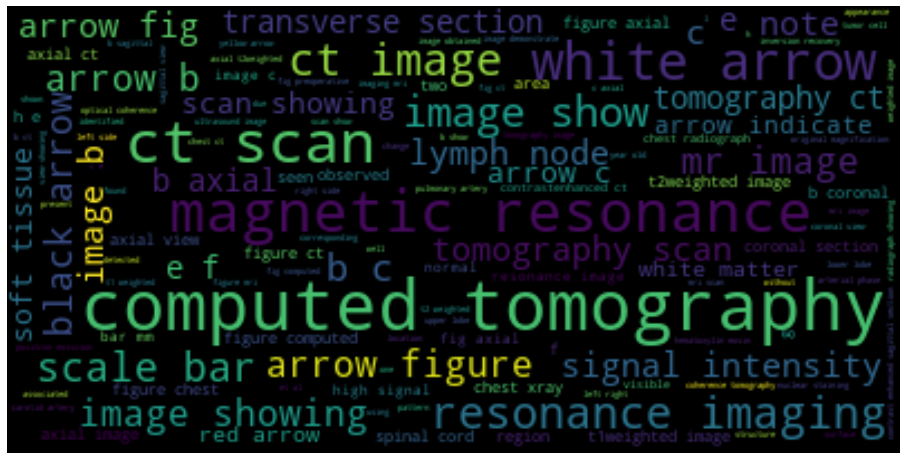

In [25]:
plt.rcParams["figure.figsize"] = (16,12)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Wordcloud on radiology captions

In [26]:
text_radiology = ', '.join(figures_data['cleaned_text'][figures_data['radiology']==True].values)
wordcloud = WordCloud().generate(text_radiology)

(-0.5, 399.5, 199.5, -0.5)

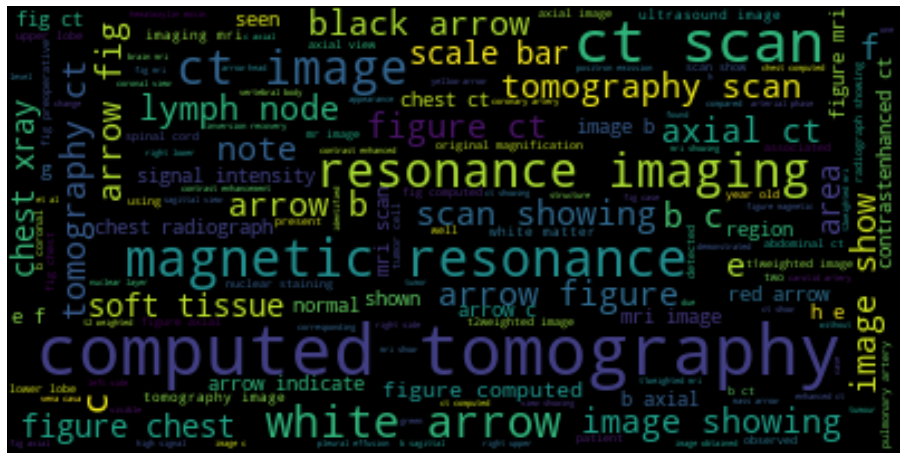

In [27]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Word cloud for class 0


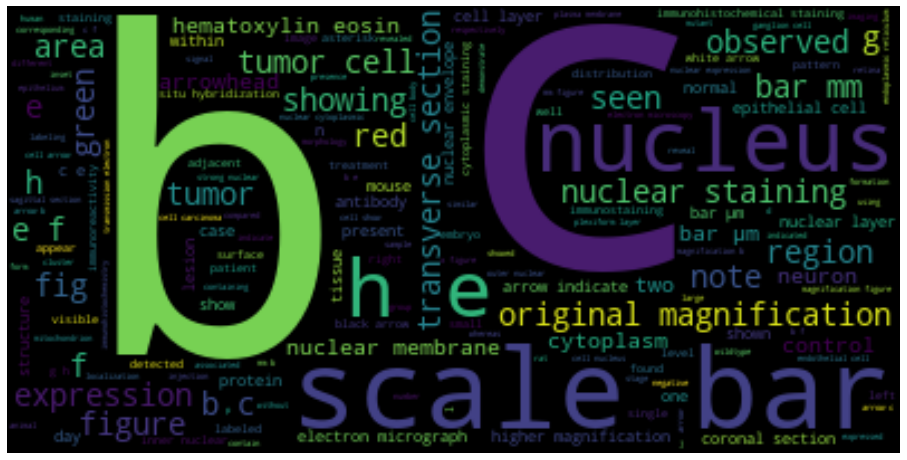

Word cloud for class 1


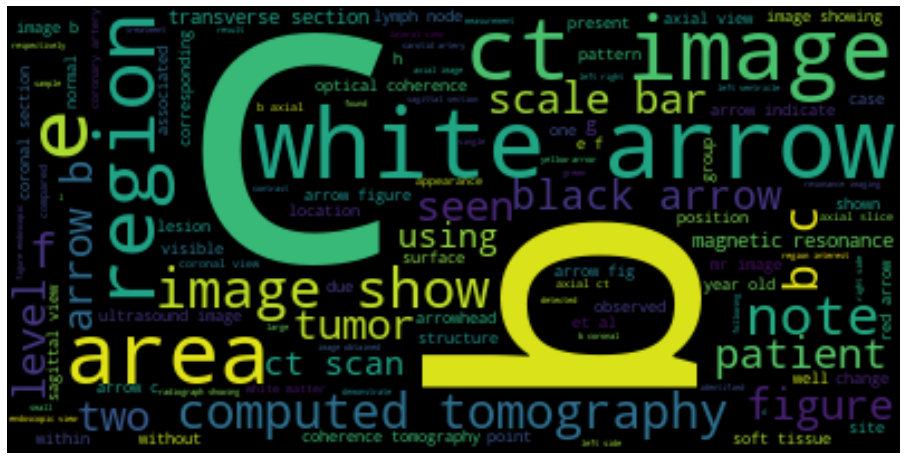

Word cloud for class 2


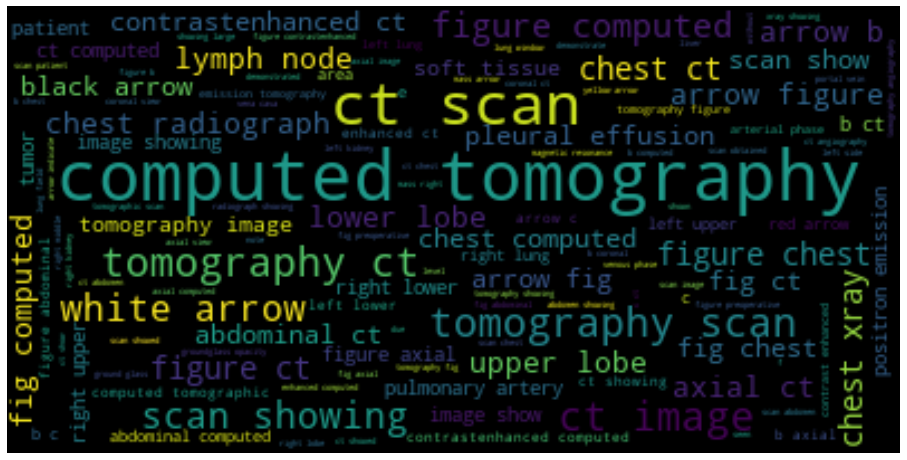

Word cloud for class 3


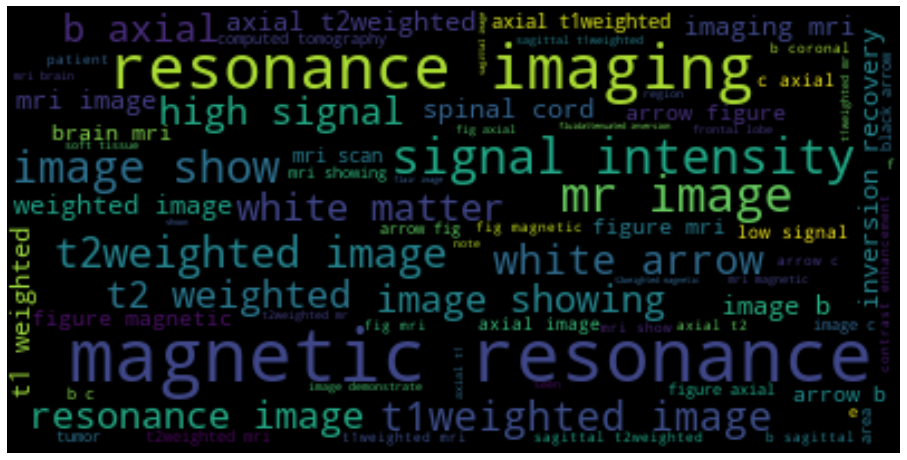

In [28]:
for i in range(4):
    print("Word cloud for class {}".format(i))
    text_radiology = ', '.join(figures_data[y_pred==i]['cleaned_text'].values)
    wordcloud = WordCloud().generate(text_radiology)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
plt.show()

In [29]:
figures_data[y_pred==2].shape, figures_data[y_pred==3].shape

((45114, 14), (32863, 14))

In [30]:
# Saving data for training 
figures_data[y_pred==2].to_csv('CT_cluster_data.csv')
figures_data[y_pred==3].to_csv('MRI_cluster_data.csv')

## Plotting some image examples

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


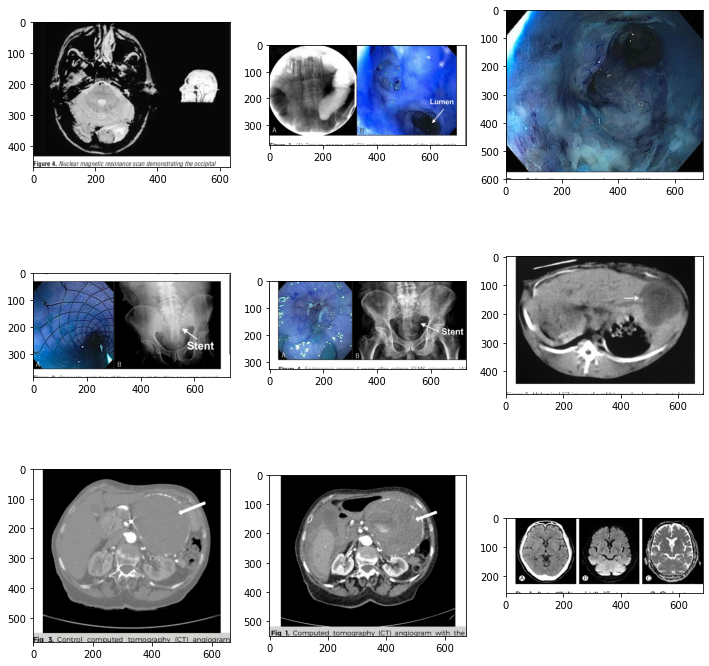

In [36]:
imgs = [cv2.imread(os.path.join('./figures/', caption_to_figure(caption_dict))) 
        for caption_dict in [figures_data.iloc[i] for i in range(9)]
        ]

_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray')
plt.show()